### Survival model 

Here we want to build propre statistic model to access impact on survival accounting for covariates.

First we want to validate a simple model on long vs short format to confirm that there is no time dependencies as the KM curve didn't overlap. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import warnings 
import pytz
import pymc as pm
from pytensor import tensor as T
import arviz as az
from pymc.distributions.timeseries import GaussianRandomWalk

from cubee.configs.filepath import formatted_datapath, raw_datapath

warnings.filterwarnings("ignore")

In [18]:
LOWER_PRIOR = 1.05
HIGH_PRIOR = 1.4
interval_length = 60
ROLLING_CUBEE_MONTH = 2
n_samples = 500
n_tune = 1000

### 0. Load data

In [19]:
data = pd.read_csv(formatted_datapath)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
data.head()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_id,brood_pattern,stings,hid,hive_interacted,death
0,0,30,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
1,30,59,1,39,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
2,59,89,1,74,0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
3,89,118,1,98,0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
4,118,148,1,125,1,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False


### Quick look at the short format

In [20]:
cubee_dose = data.groupby("hid")['cubee'].sum().reset_index()
states = data.groupby("hid")[['death','hive_age']].max().reset_index()
short = pd.merge(states,cubee_dose,on="hid",how="left")
short['cubee'] = short['cubee'].fillna(0)

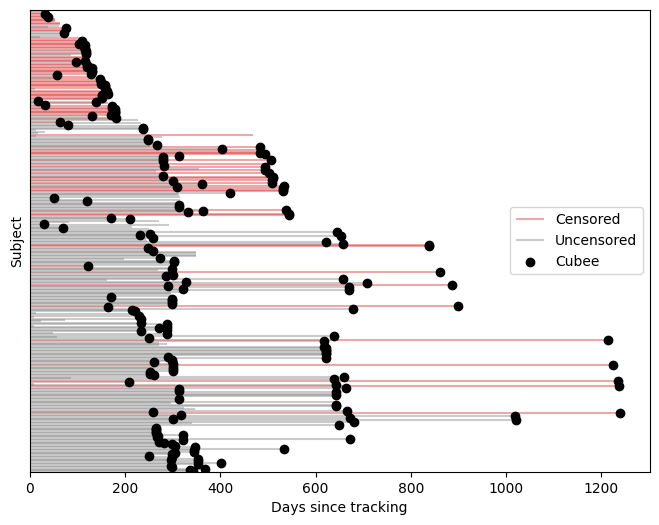

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
short['cubee_bool'] = short['cubee'] > 1
short = short.sort_values(["hive_age"])
ax.hlines(
    short[short.death==0].index, 0, short[short.death==0].hive_age, color="C3", label="Censored",alpha=0.4
)

ax.hlines(
    short[short.death==1].index, 0, short[short.death==1].hive_age, color="C7", label="Uncensored",alpha=0.4
)

ax.scatter(
    short[short.cubee.values >0].hive_age,
    short[short.cubee.values > 0].index,
    color="k",
    zorder=4,
    label="Cubee",
)

ax.set_xlim(left=0)
ax.set_xlabel("Days since tracking")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, len(short) + 0.25)

ax.legend(loc="center right");

### 1. Create a simple Bayesian CoxPH model

In [22]:

interval_bounds = np.arange(0, short.hive_age.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

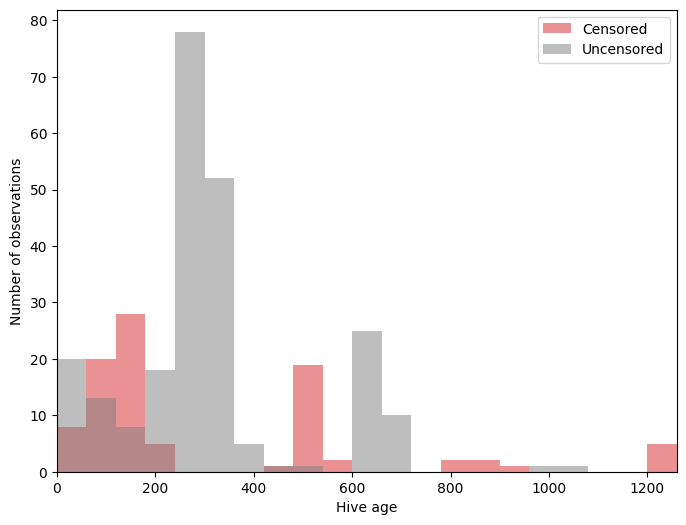

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    short[short.death == 0].hive_age.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    short[short.death == 1].hive_age.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Hive age")

# ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();

In [24]:
last_period = np.floor((short.hive_age - 0.01) / interval_length).astype(int)
n_hives = len(short)
death = np.zeros((n_hives, n_intervals))
death[short.index, last_period] = short.death.fillna(True)
exposure = np.greater_equal.outer(short.hive_age.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[short.index, last_period] = short.hive_age - interval_bounds[last_period]
exposure = np.absolute(exposure)

In [25]:
coords = {"intervals": intervals}

x = short['cubee_bool']

with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=2)

    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * x), lambda0))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [26]:

with model:
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


In [27]:
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

### Time varying

Group cubee on 3 months span 

In [28]:
data['cubee'] = data.groupby("hid")['cubee'].rolling(ROLLING_CUBEE_MONTH).sum().reset_index()['cubee']
data['cubee'] = data['cubee'].fillna(0)

In [29]:
time_varying_interval_bounds = np.arange(0, data.hive_age.max() + interval_length + 1, interval_length)
n_intervals = time_varying_interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [30]:
last_period = np.floor((data.hive_age - 0.01) / interval_length).astype(int)
n_hives = len(data)
death = np.zeros((n_hives, n_intervals))
death[data.index, last_period] = data.death.fillna(True)
exposure = np.greater_equal.outer(data.hive_age.to_numpy(), time_varying_interval_bounds[:-1]) * interval_length
exposure[data.index, last_period] = data.hive_age - time_varying_interval_bounds[last_period]
exposure = np.absolute(exposure)

In [31]:
data.fob = data.fob.fillna(data.fob.mean())

In [32]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as time_varying_model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")
    lambda1 = pm.Poisson("lambda1", 0.5, dims="intervals")
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=2.0, dims="intervals")

    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(data.cubee), beta)))
    lambda_2 = pm.Deterministic("h2", lambda1 * T.exp(T.outer(T.constant(data.fob), beta)))
    mu = pm.Deterministic("mu", exposure * lambda_ + exposure * lambda_2)

    obs = pm.Poisson("obs", mu, observed=death)

In [33]:
with time_varying_model:
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=8,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda0, beta]
>Metropolis: [lambda1]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
tv_base_hazard = time_varying_idata.posterior["lambda0"] + time_varying_idata.posterior["lambda1"]
tv_met_hazard = (time_varying_idata.posterior["lambda0"] * np.exp(
    time_varying_idata.posterior["beta"]
)) + (time_varying_idata.posterior["lambda1"] * np.exp(
    time_varying_idata.posterior["beta"]
))

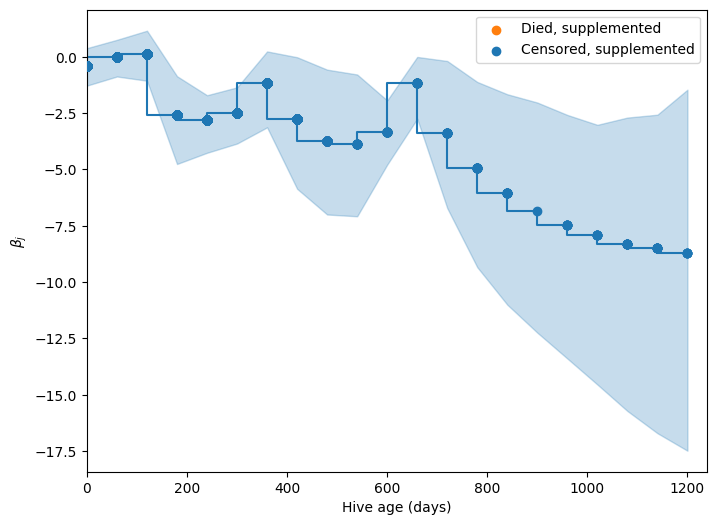

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_eti = time_varying_idata.posterior["beta"].quantile((0.025, 0.975), dim=("chain", "draw"))
beta_eti_low = beta_eti.sel(quantile=0.025)
beta_eti_high = beta_eti.sel(quantile=0.975)

ax.fill_between(time_varying_interval_bounds[:-1], beta_eti_low, beta_eti_high, color="C0", alpha=0.25)

beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))

ax.step(time_varying_interval_bounds[:-1], beta_hat, color="C0")

ax.scatter(
    time_varying_interval_bounds[last_period[(data.death.values == 1) & (data.cubee > 0)]],
    beta_hat.isel(intervals=last_period[(data.death.values == 1) & (data.cubee > 0)]),
    color="C1",
    zorder=10,
    label="Died, supplemented",
)

ax.scatter(
    time_varying_interval_bounds[last_period[(data.death.values == 0) & (data.cubee >= 0)]],
    beta_hat.isel(intervals=last_period[(data.death.values == 0) & (data.cubee >= 0)]),
    color="C0",
    zorder=10,
    label="Censored, supplemented",
)

ax.set_xlim(0, data.hive_age.max())
ax.set_xlabel("Hive age (days)")
ax.set_ylabel(r"$\beta_j$")
ax.legend();

In [36]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

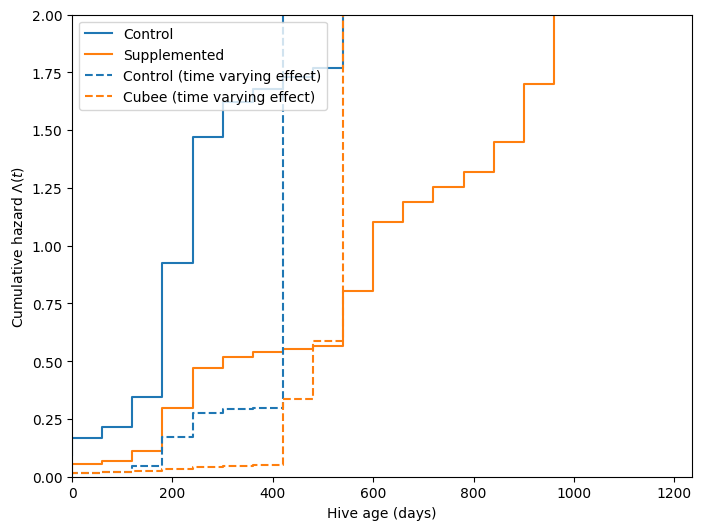

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(
    interval_bounds[:-1],
    cum_hazard(base_hazard.mean(("chain", "draw"))),
    color="C0",
    label="Control",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(met_hazard.mean(("chain", "draw"))),
    color="C1",
    label="Supplemented",
)

ax.step(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_base_hazard.mean(("chain", "draw"))),
    color="C0",
    linestyle="--",
    label="Control (time varying effect)",
)

ax.step(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_met_hazard.mean(dim=("chain", "draw"))),
    color="C1",
    linestyle="--",
    label="Cubee (time varying effect)",
)

ax.set_xlim(0, short.hive_age.max() - 4)
ax.set_xlabel("Hive age (days)")
ax.set_ylim(0, 2)
ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
ax.legend(loc=2);

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'beta\n3'}>], dtype=object)

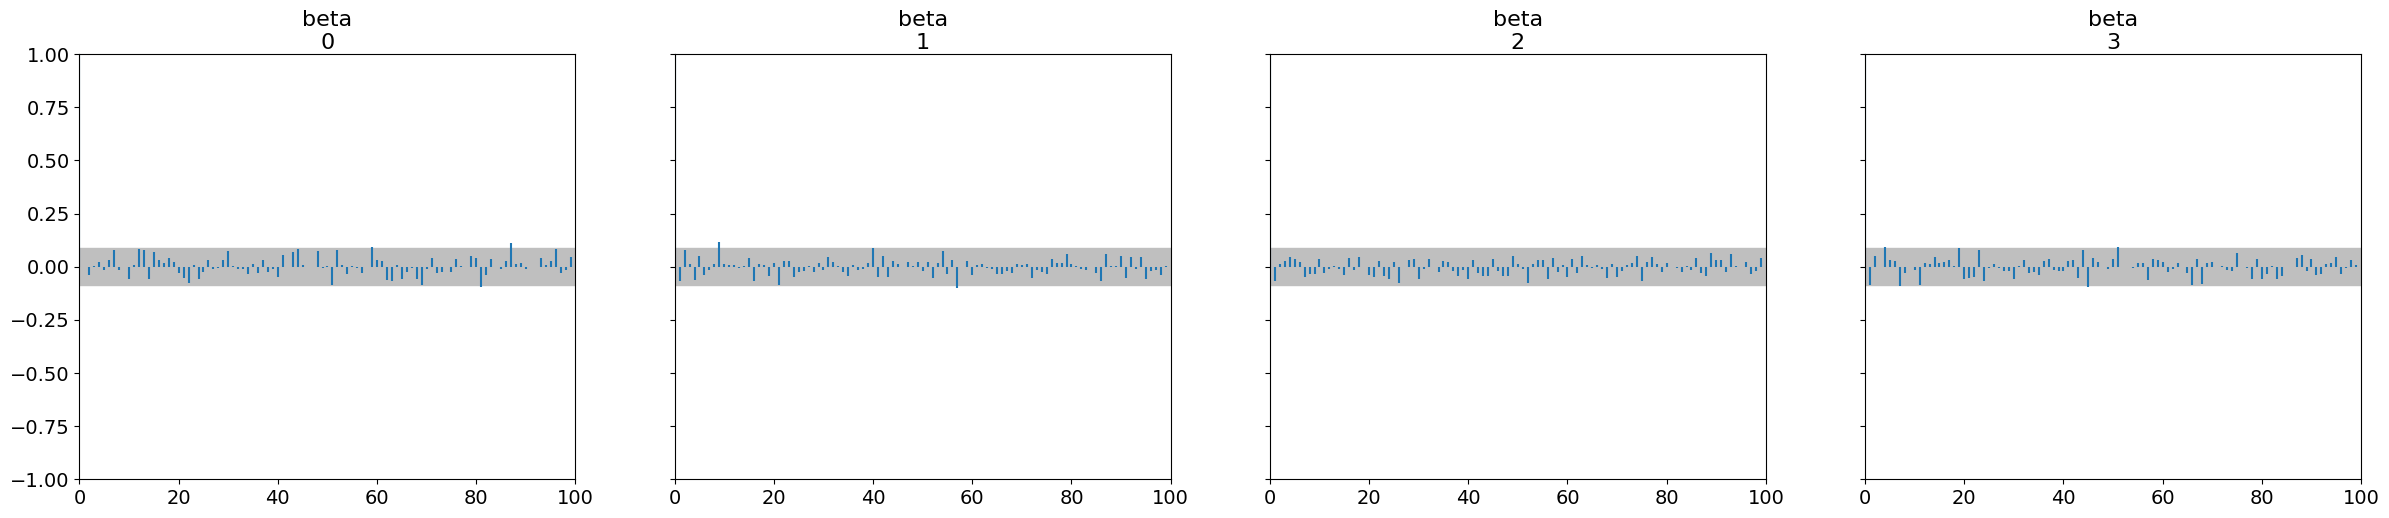

In [38]:
az.plot_autocorr(idata, var_names=["beta"])

<Axes: title={'center': 'beta'}>

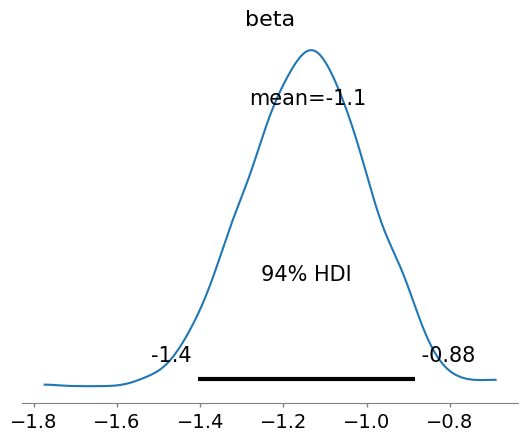

In [39]:
az.plot_posterior(idata, var_names=["beta"])

array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n0, 2'}>,
        <Axes: title={'center': 'beta\n0, 3'}>],
       [<Axes: title={'center': 'beta\n0, 4'}>,
        <Axes: title={'center': 'beta\n0, 5'}>,
        <Axes: title={'center': 'beta\n0, 6'}>,
        <Axes: title={'center': 'beta\n0, 7'}>],
       [<Axes: title={'center': 'beta\n0, 8'}>,
        <Axes: title={'center': 'beta\n0, 9'}>,
        <Axes: title={'center': 'beta\n0, 10'}>,
        <Axes: title={'center': 'beta\n0, 11'}>],
       [<Axes: title={'center': 'beta\n0, 12'}>,
        <Axes: title={'center': 'beta\n0, 13'}>,
        <Axes: title={'center': 'beta\n0, 14'}>,
        <Axes: title={'center': 'beta\n0, 15'}>],
       [<Axes: title={'center': 'beta\n0, 16'}>,
        <Axes: title={'center': 'beta\n0, 17'}>,
        <Axes: title={'center': 'beta\n0, 18'}>,
        <Axes: title={'center': 'beta\n0, 19'}>],
       [<Axes: title={'ce

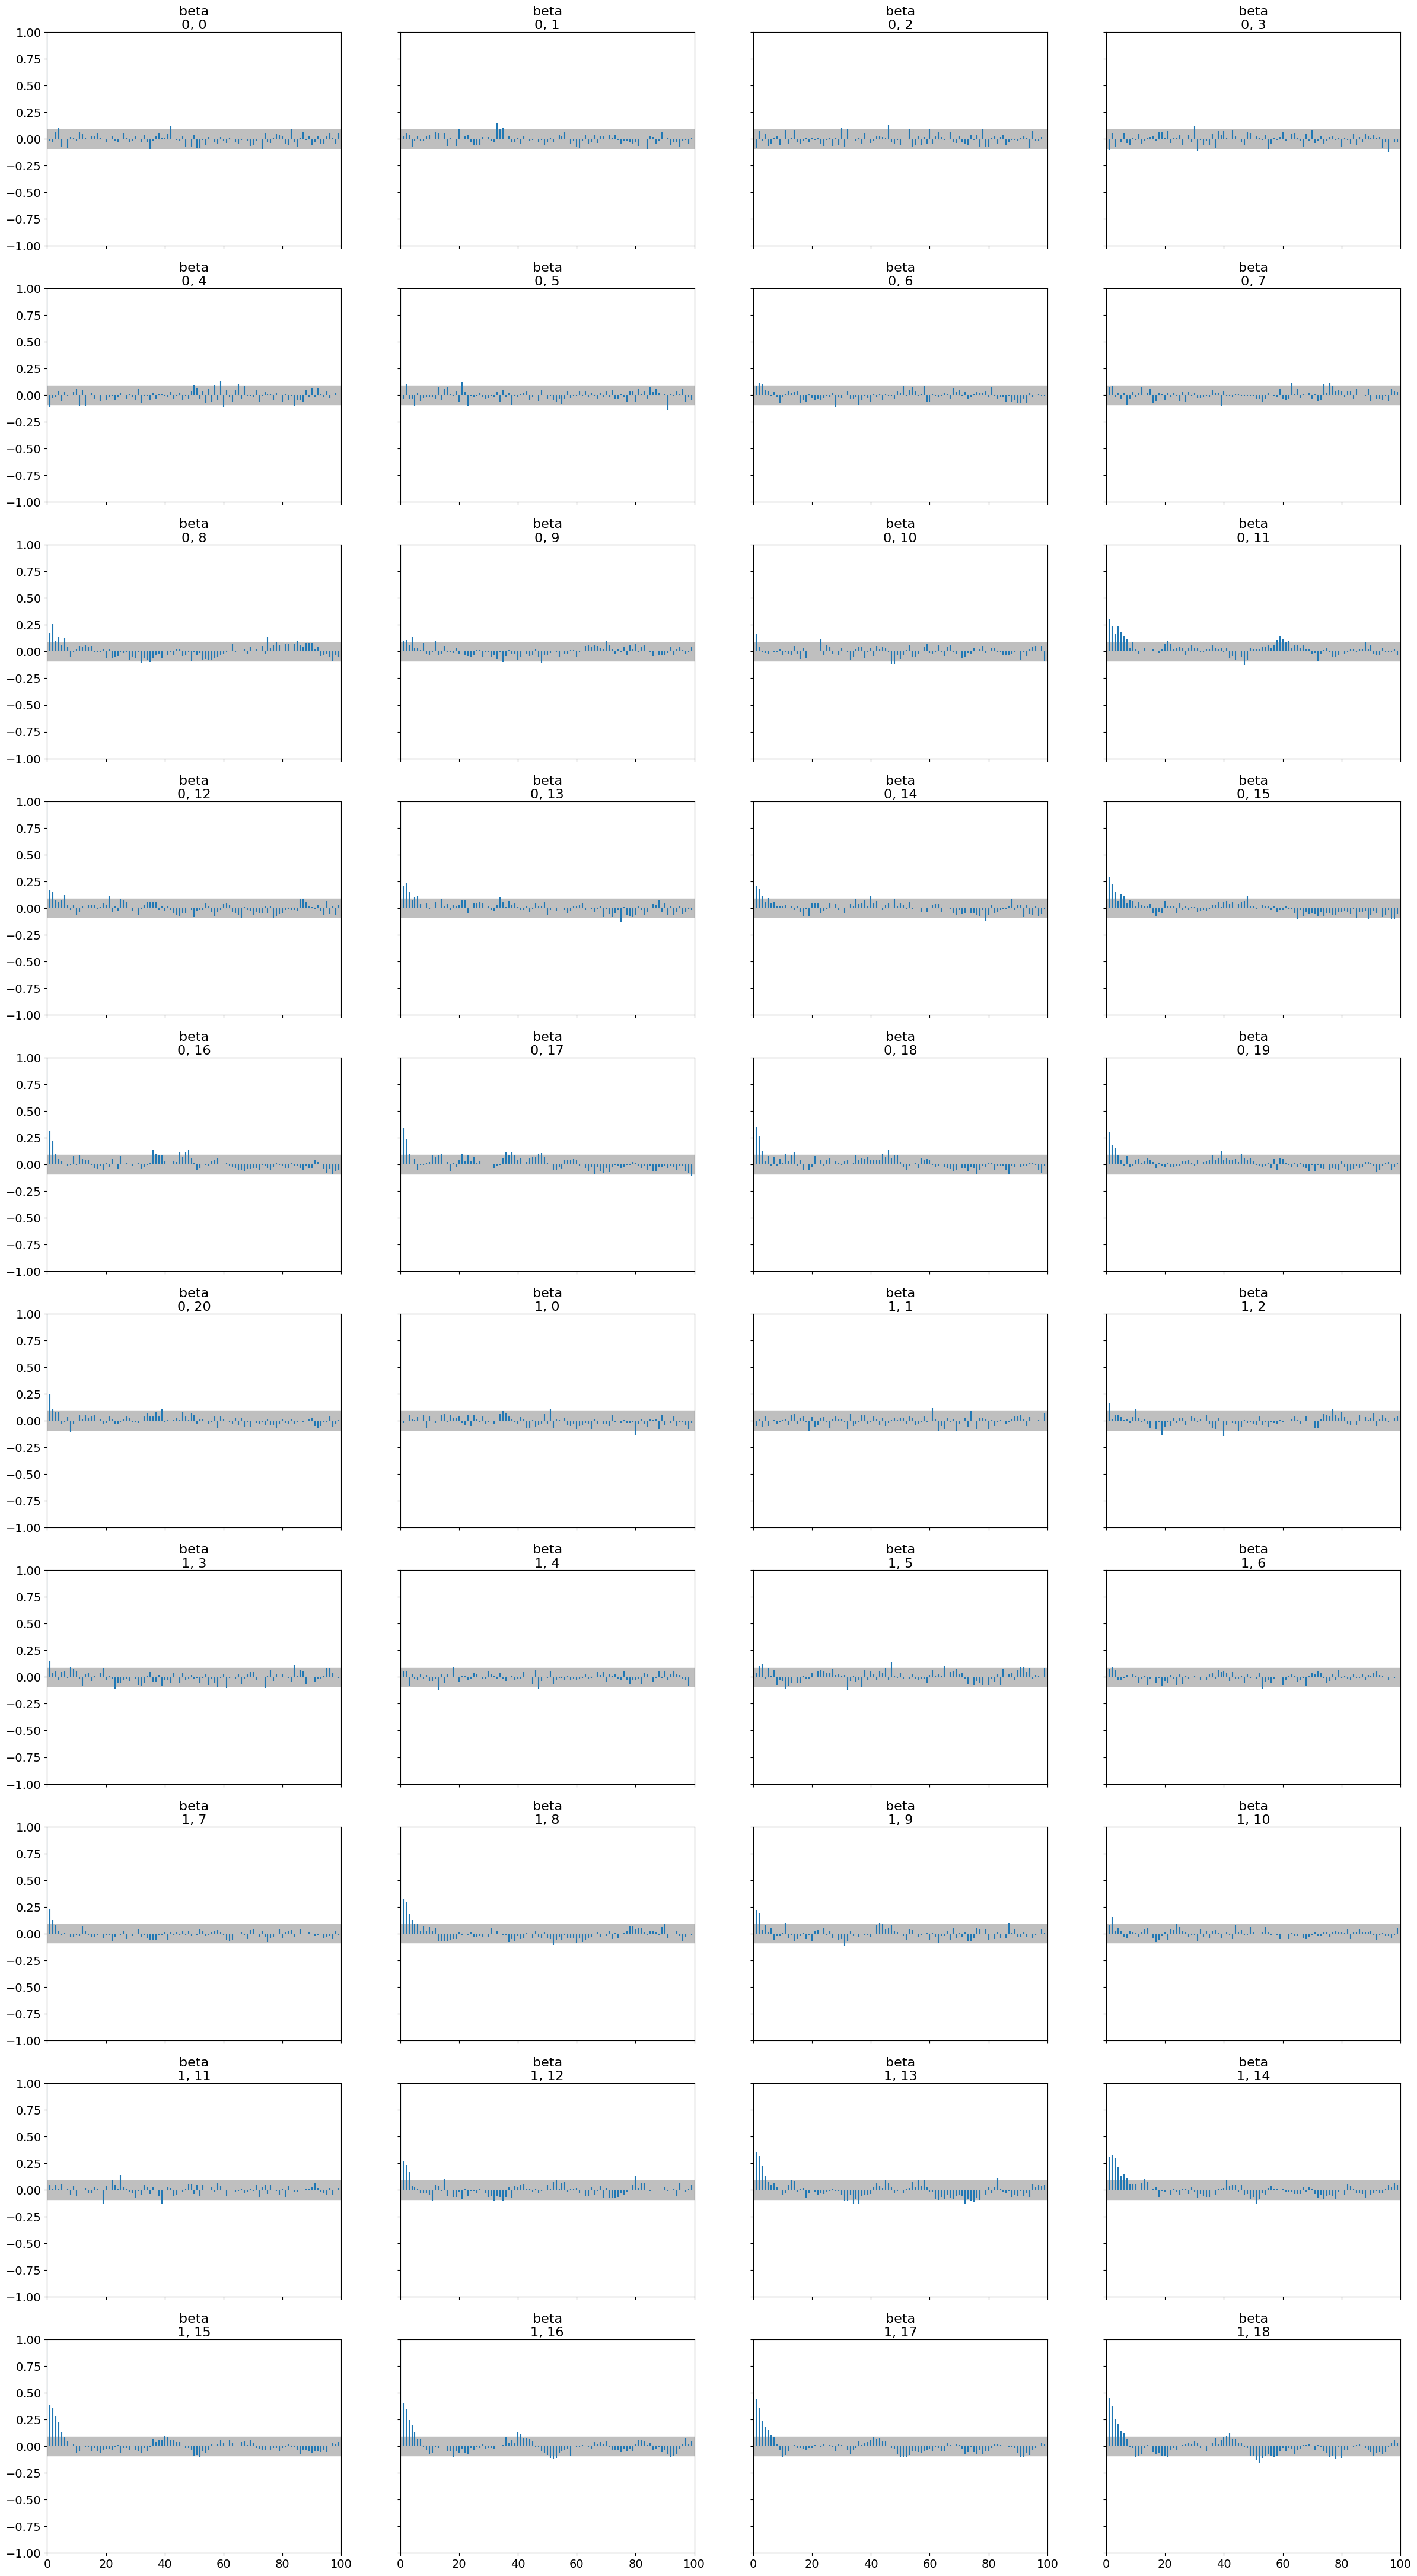

In [40]:
az.plot_autocorr(time_varying_idata, var_names=["beta"])

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>],
       [<Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta\n11'}>],
       [<Axes: title={'center': 'beta\n12'}>,
        <Axes: title={'center': 'beta\n13'}>,
        <Axes: title={'center': 'beta\n14'}>],
       [<Axes: title={'center': 'beta\n15'}>,
        <Axes: title={'center': 'beta\n16'}>,
        <Axes: title={'center': 'beta\n17'}>],
       [<Axes: title={'center': 'beta\n18'}>,
        <Axes: title={'center': 'beta\n19'}>,
        <Axes: title={'center': 'beta\n20'}>]], dtype=object)

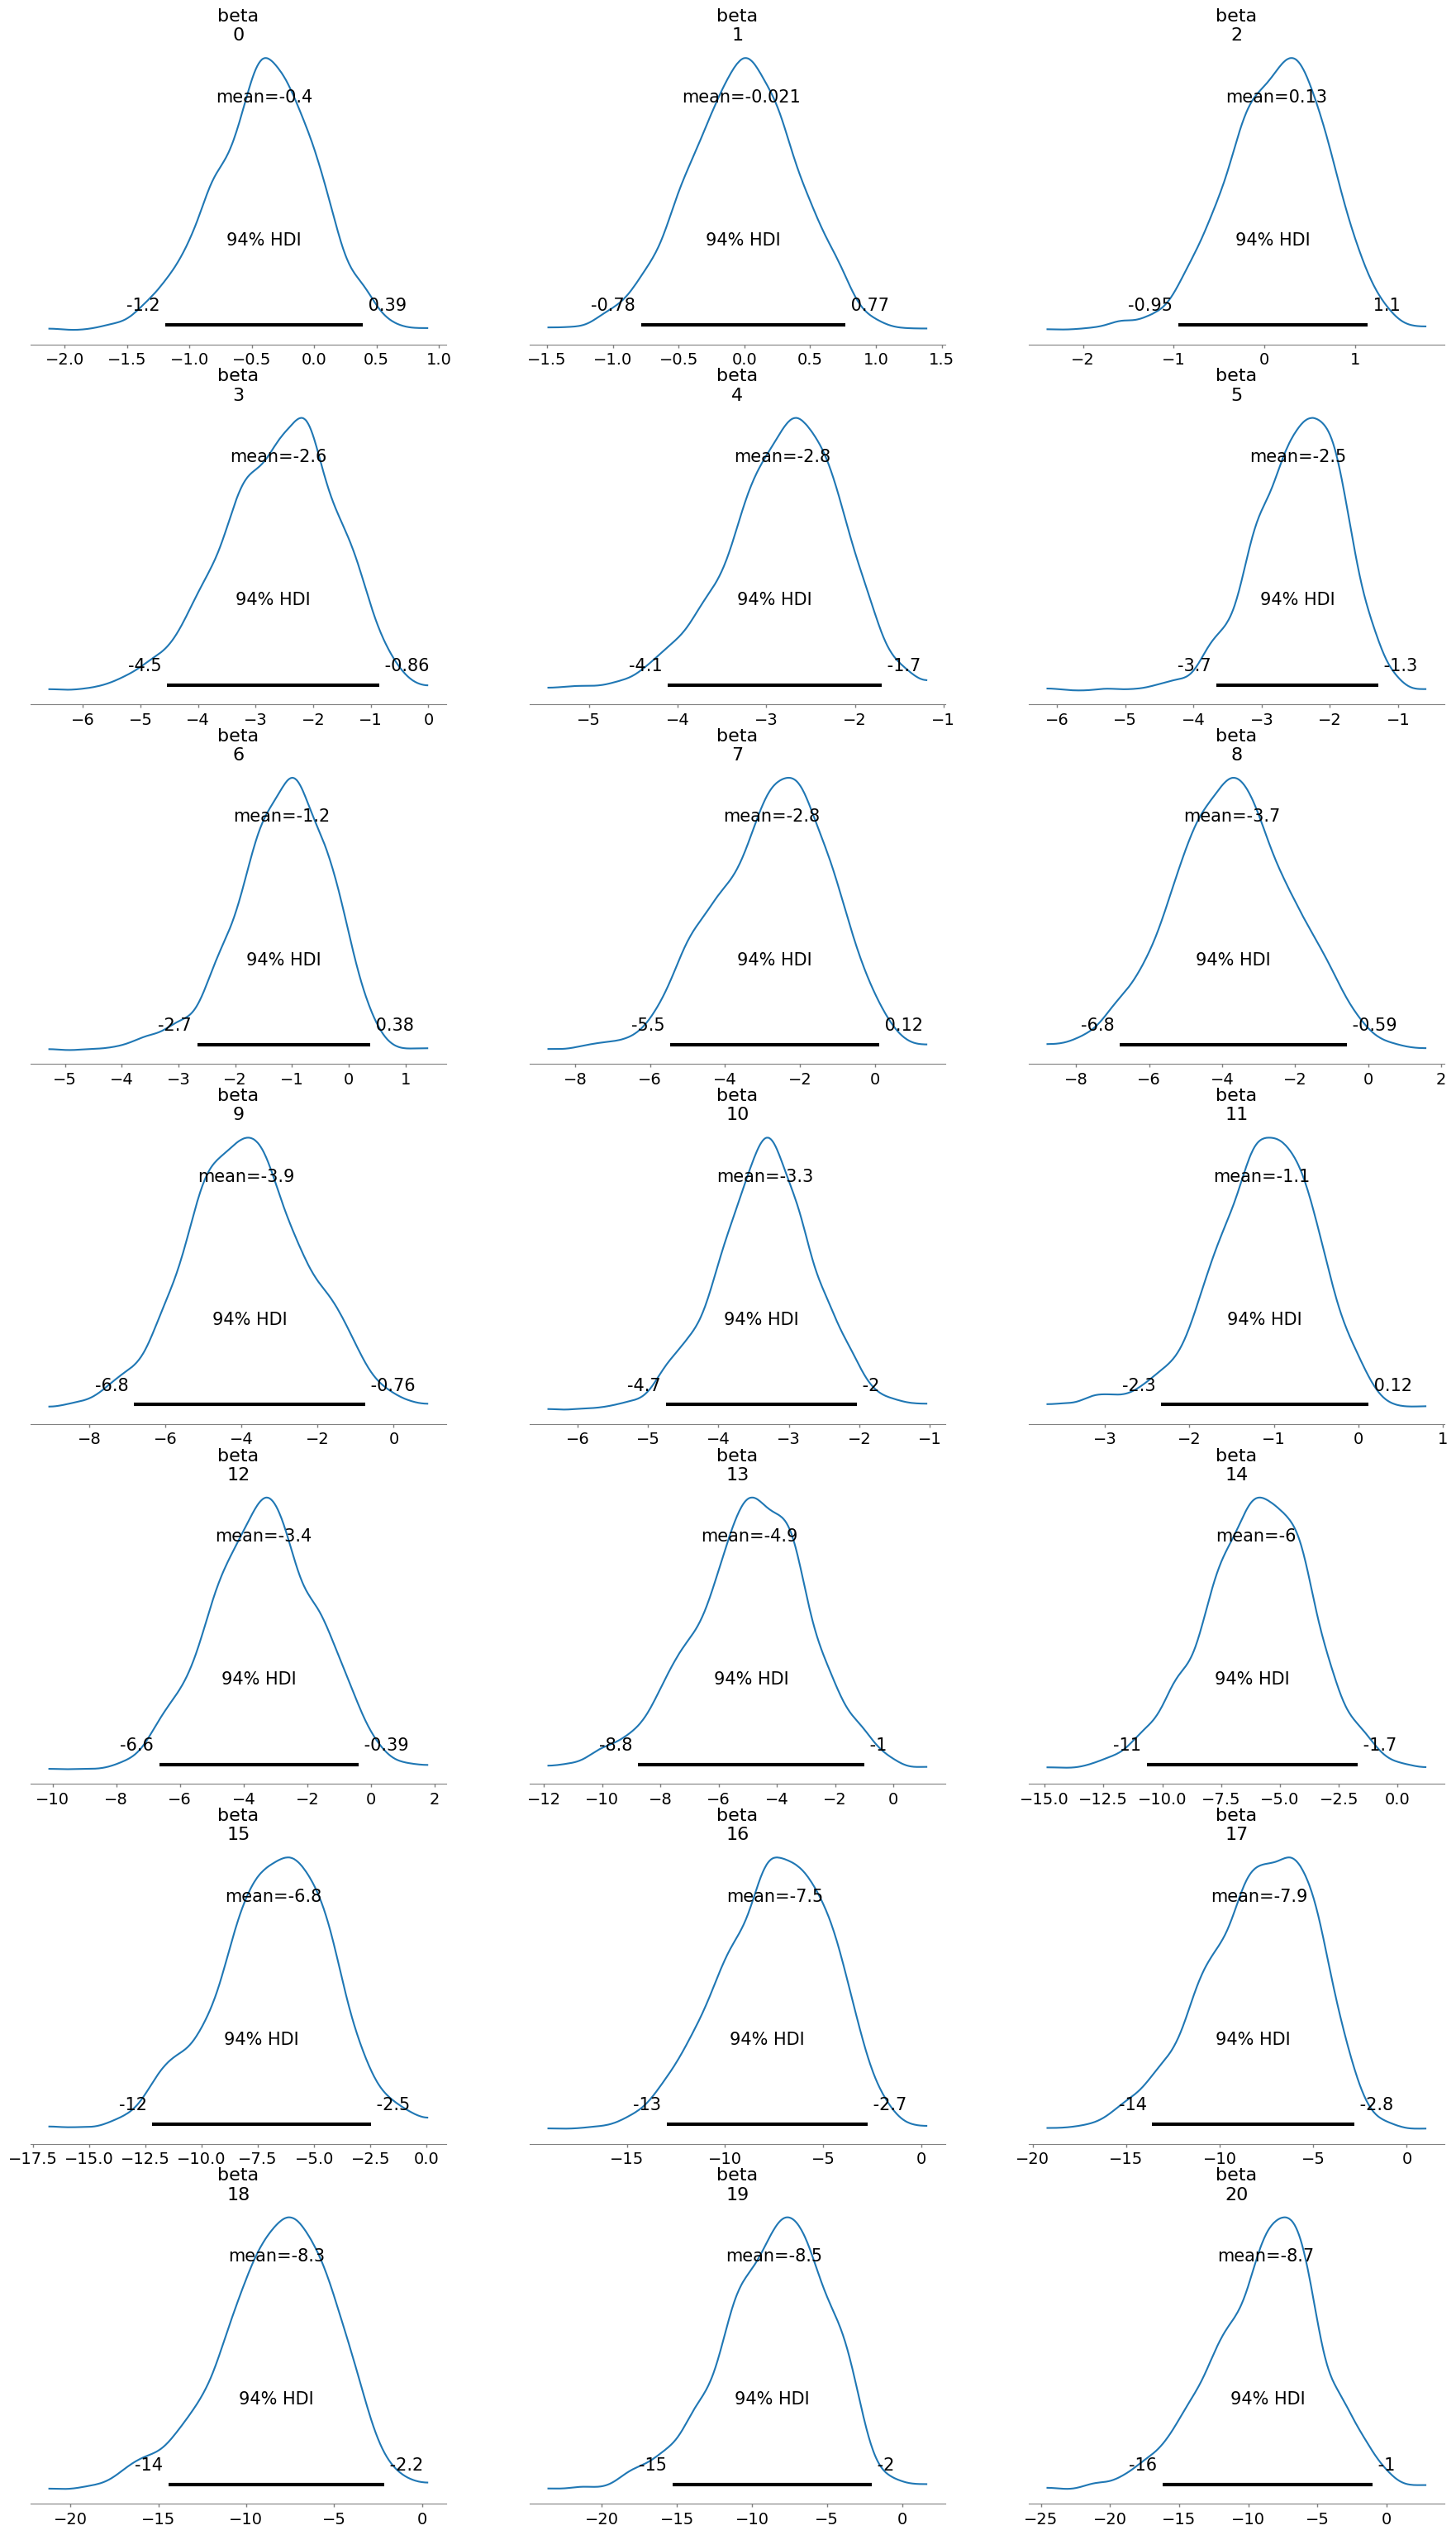

In [41]:
az.plot_posterior(time_varying_idata, var_names=["beta"])

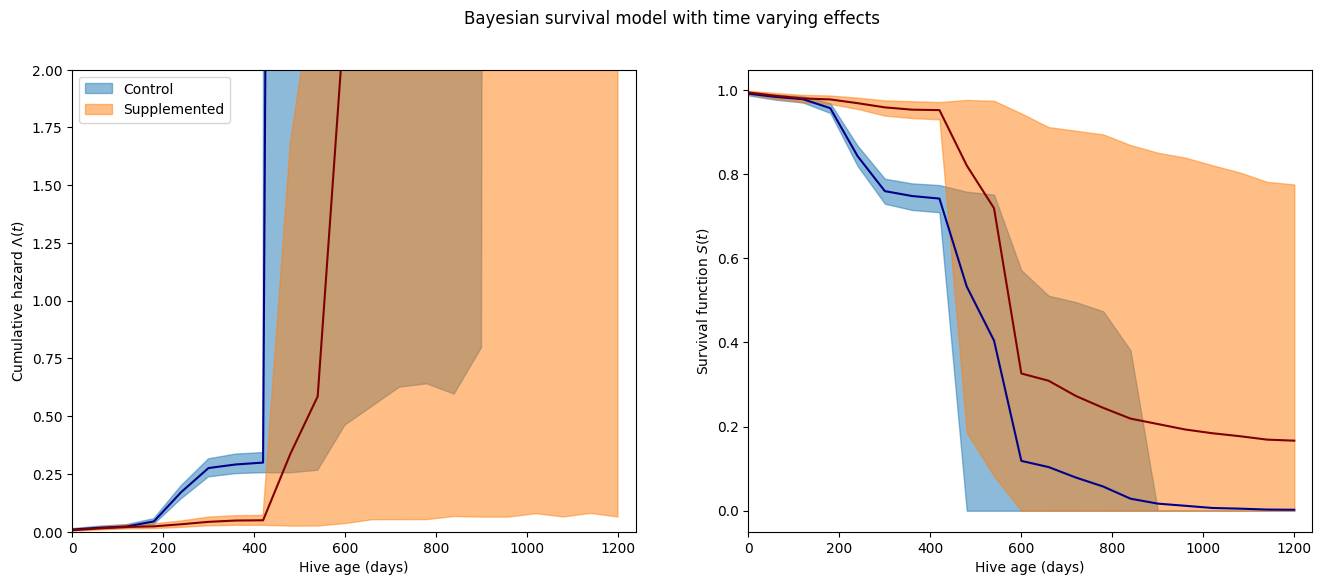

In [42]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_base_hazard),
    ax=hazard_ax,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "Control"},
)

az.plot_hdi(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(time_varying_interval_bounds[:-1], get_mean(cum_hazard(tv_base_hazard)), color="darkblue")
hazard_ax.plot(time_varying_interval_bounds[:-1], get_mean(cum_hazard(tv_met_hazard)), color="maroon")

hazard_ax.set_xlim(0, short.hive_age.max())
hazard_ax.set_xlabel("Hive age (days)")
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(time_varying_interval_bounds[:-1], survival(tv_base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(time_varying_interval_bounds[:-1], survival(tv_met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(time_varying_interval_bounds[:-1], get_mean(survival(tv_base_hazard)), color="darkblue")
surv_ax.plot(time_varying_interval_bounds[:-1], get_mean(survival(tv_met_hazard)), color="maroon")

surv_ax.set_xlim(0, short.hive_age.max())
surv_ax.set_xlabel("Hive age (days)")
surv_ax.set_ylabel("Survival function $S(t)$")
fig.suptitle("Bayesian survival model with time varying effects");

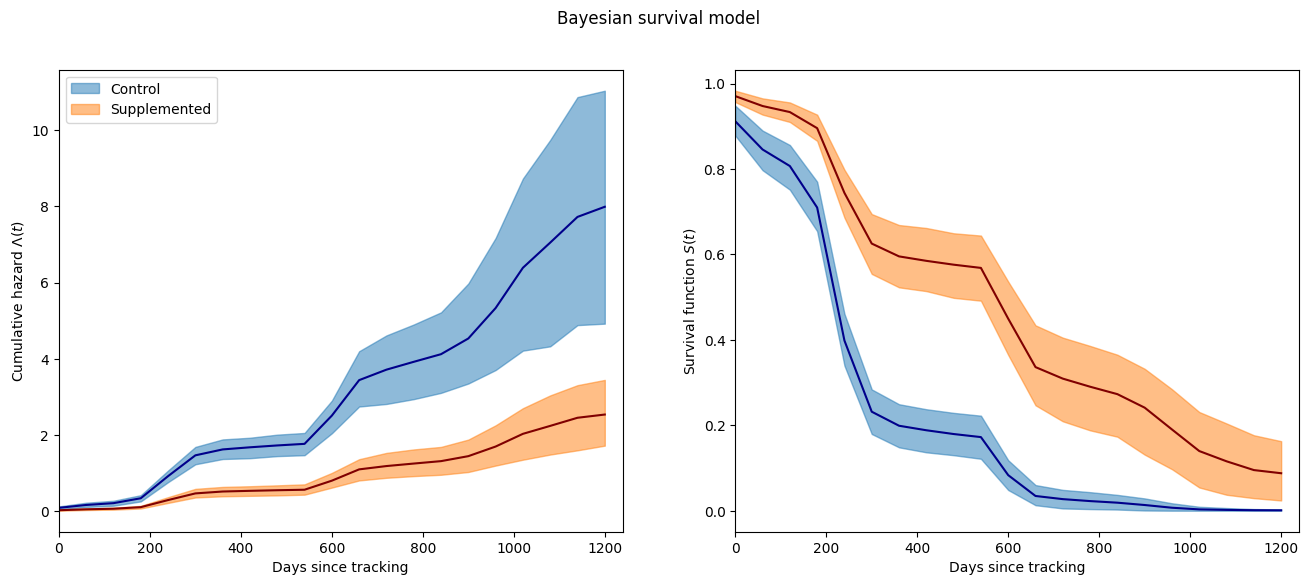

In [43]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Control"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, short.hive_age.max())
hazard_ax.set_xlabel("Days since tracking")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, short.hive_age.max())
surv_ax.set_xlabel("Days since tracking")
surv_ax.set_ylabel("Survival function $S(t)$")

fig.suptitle("Bayesian survival model");